In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import itertools
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

import math
import argparse
import torch.optim as optim
from torch import nn
from pathlib import Path

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def reader(filep):
  with open(filep, "r") as f:
    data = f.readlines()
  data = [da.strip() for da in data]
  return data


def get_list_kmer(kmer, string="TGCA"):
  string = list(string)
  lkmer = ["".join(p) for p in itertools.product(string, repeat=kmer)]
  lkmer.sort()
  return lkmer


def protein2num(protein, elements):
  kmer = len(elements[0])
  edict = dict()
  for i, ele in enumerate(elements):
    edict[ele] = i
  token = list()
  for i in range(len(protein)-kmer+1):
    try:
      token.append(edict[protein[i:i+kmer]])
    except KeyError:
      token.append(0)
      print("Key error : ", protein[i:i+kmer], i)
  return token


def neggen(protein, num_part=20, keep=8, max_class=4):
  length = len(protein)
  # get part
  part_len = length // num_part
  if part_len * num_part < length:
    num_part += 1

  iterator = np.arange(num_part)
  keep_parts = random.sample(list(iterator), k=keep)

  outpro = list()
  for it in iterator:
    start = it * part_len
    pro_part = protein[start:start + part_len]
    if it in keep_parts:
      outpro.extend(pro_part)
    else:
      pro_part = random.choices(np.arange(max_class), k=len(pro_part))
      outpro.extend(pro_part)
  return outpro

In [ ]:
class LoadOnehot(Dataset):
  def __init__(self, pathpos, is_pos=True, device="cuda", fake=0, length_pro=300, divide=20, part=8):
    """
    Dataset
    :param pathpos: Path to the txt data file
    :param is_pos: Control the label for dataset True for 1, False for 0
    :param device: Device
    :param fake: 0 for load original txt dataset , 1 for random fake, 2 for faking method as describe in the paper
    :param length_pro: Input sequence length
    :param divide: Number of part to break protein into before replace some part with random sequence
    :param part: Number of part to keep the same when do random subsequence
    """
    if is_pos and fake != 0:
      raise Exception("Cant use key word fake on positive dataset")
    self.device = device
    self.fake = fake
    self.length_pro = length_pro
    self.divide = divide
    self.part = part

    # get list of kmer
    dic = get_list_kmer(1)

    # read data from file
    self.dpos = reader(pathpos)

    # convert protein to number sequence
    self.npos = [protein2num(pro, dic) for pro in self.dpos]

    if is_pos:
      self.poslabel = torch.from_numpy(np.ones(len(self.dpos)))
    else:
      # ic("go false")
      self.poslabel = torch.from_numpy(np.zeros(len(self.dpos)))
    self.poslabel = self.poslabel.to(device)

  def __len__(self):
    return len(self.dpos)

  def __getitem__(self, idx):
    # convert data to one hot format and up to device
    pro = self.npos[idx]
    if len(pro) < self.length_pro:
      pro = pro + [0] * (self.length_pro - len(pro))
    elif len(pro) > self.length_pro:
      pro = pro[:self.length_pro]

    # random generate a fake promoter by shuffle the pro
    if self.fake == 1:
      pro = random.shuffle(pro)
    # random generate a fake promoter by replace part of pro
    elif self.fake == 2:
      pro = neggen(pro, num_part=self.divide, keep=self.part, max_class=4)

    torchpro = torch.from_numpy(np.array(pro))
    onehot = torch.nn.functional.one_hot(torchpro, num_classes=4).to(self.device)
    return onehot.float(), self.poslabel[idx]

In [ ]:
def load_data(data_path, train_potion=0.8, rand_neg=False, batch_size=32, num_cpu=0, device="cuda"):
  """
  Load all data
  :param data_path: Path to txt file contain promoter (1 DNA promoter on 1 line)
  :param train_potion: The potion of dataset spend for training
  :param rand_neg: Add random of DNA to negative datset
  :param batch_size: Batch size for loader
  :param num_cpu: Number of CPU perform load data in prallel
  :param device: Device to load data on
  :return: List of train, val, test dataset for positive and negative datset
  """
  # get dataset
  manual_seed = torch.Generator().manual_seed(42)
  pos_data = LoadOnehot(data_path, device=device)
  neg_data = LoadOnehot(data_path, is_pos=False, fake=2, device=device)

  # calculate the size of train and test dataset
  train_num = int(len(pos_data)*train_potion)
  val_num = int(len(pos_data)*(1-train_potion)*0.5)
  split_size = [train_num, val_num, len(pos_data) - train_num - val_num]

  # split dataset
  train_pos, val_pos, test_pos = random_split(pos_data, split_size, generator=manual_seed)
  train_neg, val_neg, test_neg = random_split(neg_data, split_size, generator=manual_seed)

  # add random dataset to negative dataset(only to train set)
  if rand_neg:
    neg_data_rand = LoadOnehot(data_path, is_pos=False, fake=1, device=device)
    train_neg = ConcatDataset([train_neg, neg_data_rand])

  # data loader
  stack_dataset = [train_pos, val_pos, test_pos, train_neg, val_neg, test_neg]
  stack_loaders = list()
  for dataset in stack_dataset:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
    stack_loaders.append(data_loader)

  return stack_loaders

In [ ]:
def load_data_test(data_path, batch_size=32, device="cuda", num_cpu=0):
  dataset = LoadOnehot(data_path, device=device)
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_cpu)
  return data_loader

In [ ]:
class ParallelCNN(nn.Module):
  def __init__(self, para_ker, pool_kernel=6, drop=0.5):
    """
    Multiple CNN layer apply on input and concatenate the output
    :param para_ker: List of kernel size that will be used
    :param pool_kernel: Pooling parameter after CNN
    :param drop: Dropout parameter
    """
    super(ParallelCNN, self).__init__()
    self.lseq = nn.ModuleList()
    for k in para_ker:
      seq = nn.Sequential(
        nn.Conv1d(4, 4, kernel_size=k, padding="same"),
        nn.ReLU(),
        nn.MaxPool1d(pool_kernel),
        nn.Dropout(drop)
      )
      self.lseq.append(seq)

  def forward(self, inputs):
    """
    :param inputs: DNA onehot sequences [batch_size x 4 x length]
    :return: Stack CNN output feature from different kernel size [batch_size x 12 x length]
    """
    _x = list()
    for seq in self.lseq:
      x = seq(inputs)
      _x.append(x)
    # concate outputs of every conv layer to a tensor
    _x = torch.cat(_x, 1)
    return _x

In [ ]:
class BidirectionalLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(BidirectionalLSTM, self).__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
    self.linear = nn.Linear(hidden_size * 2, output_size)

  def forward(self, inputs):
    """
    :param inputs: visual feature [batch_size x T x input_size]
    :return: contextual feature [batch_size x T x output_size]
    """

    self.rnn.flatten_parameters()
    recurrent, _ = self.rnn(inputs)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
    output = self.linear(recurrent)  # batch_size x T x output_size
    return output

In [ ]:
class DeePromoter(nn.Module):
  def __init__(self, para_ker, input_shape=(64, 300, 4), pool_kernel=6, drop=0.5):
    """
    Deepromoter
    :param para_ker: List of kernel size that will be used
    :param input_shape: Specifies the input shape for model(fixed)
    :param pool_kernel: Pooling parameter after CNN
    :param drop: Dropout parameter
    """
    super(DeePromoter, self).__init__()
    binode = len(para_ker) * 4

    self.pconv = ParallelCNN(para_ker, pool_kernel, drop)
    self.bilstm = BidirectionalLSTM(binode, binode, binode)
    self.flatten = nn.Flatten()
    x = torch.zeros(input_shape)
    shape = self.get_feature_shape(x)

    self.fc = nn.Sequential(
      nn.Linear(shape, shape),
      nn.ReLU(),
      nn.Linear(shape, 2),
      nn.Softmax(dim=1)
    )

  def get_feature_shape(self, x):
    """Pass a dummy input through to find the shape
    after flatten layer for Linear layer construction"""
    x = x.permute(0, 2, 1)
    x = self.pconv(x)
    x = x.permute(0, 2, 1)
    x = self.bilstm(x)
    x = self.flatten(x)
    return x.shape[1]

  def forward(self, x):
    x = x.permute(0, 2, 1)
    x = self.pconv(x)
    x = x.permute(0, 2, 1)
    x = self.bilstm(x)
    x = self.flatten(x)
    x = self.fc(x)
    return x

In [ ]:
def evaluate(net, loaders):
  """
  Infer and check results against labels
  :param net: Model object in eval state
  :param loaders: List of torch dataloader for infer
  :return: List of [correct, total] for every dataloader, list of predicted results in int type
  """
  eval_result = list()
  ltotal = list()
  lcorrect = list()
  pred_result = list()
  for load in loaders:
    total = 0
    correct = 0
    pred_list = list()
    for data in load:
      inputs = data[0]
      labels = data[1]
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      pred_list += list(predicted.cpu().numpy())
    acc = correct/total
    eval_result.append(acc)
    lcorrect.append(correct)
    ltotal.append(total)
    pred_result.append(pred_list)
  return (lcorrect, ltotal), pred_result

In [ ]:
def mcc(data):
  """
  Calculate Matthew correlation coeficient
  :param data: List output of evaluate with the first item is positive result and second item is negative result
  :return: Precision, recall, MCC
  """
  pos_count = data[0][0]
  neg_count = data[0][1]

  tol_pos_count = data[1][0]
  tol_neg_count = data[1][1]

  TP = pos_count
  FN = tol_pos_count - pos_count
  TN = neg_count
  FP = tol_neg_count - neg_count

  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

  return precision, recall, MCC

In [ ]:
def test(data_path, pretrain, ker=None):
  if ker is None:
    ker = [27, 14, 7]

  dataloader = load_data_test(data_path, device=device)

  # model define
  net = DeePromoter(ker)
  net.to(device)

  net.load_state_dict(torch.load(pretrain))

  net.eval()
  eval_data, results = evaluate(net, [dataloader])

  return results

In [ ]:
def test_main():
  parser = argparse.ArgumentParser()
  parser.add_argument(
    "-d",
    "--data",
    type=str,
    required=True,
    help="path to dataset(txt file)",
  )
  parser.add_argument("-w", "--weight", type=str, help="Path to pre-train")
  args = parser.parse_args()

  output = test(args.data, args.weight)

  with open("infer_results.txt", "w") as f:
    for out in output[0]:
      f.write(str(out) + "\n")

Positive and Negative Data Count for Human TATA

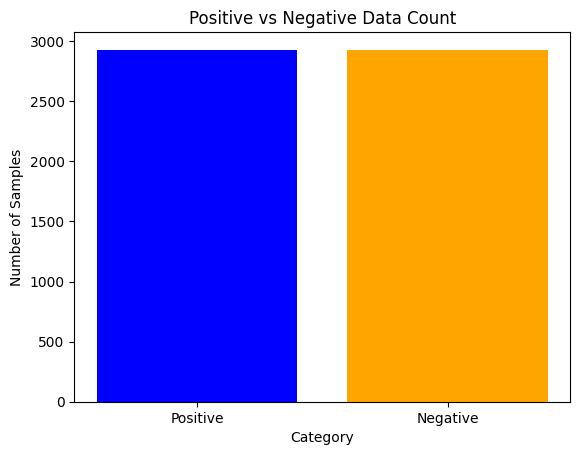

## Train

In [ ]:
def train(data_path, pretrain=None, exp_name="test", training=True, ker=None, epoch_num=1000):
  """
  Training
  :param data_path: Path to the txt data file
  :param pretrain: Path to weight for continue training
  :param exp_name: Folder name to save the results
  :param training: If False, performs testing only
  :param ker: List kernel size of list CNN applying to the protein sequence
  :param epoch_num: Max epoch to train
  """
  if ker is None:
    ker = [27, 14, 7]

  # create the experiment folder to save the result
  output = Path("./output")
  output.mkdir(exist_ok=True)
  exp_folder = output.joinpath(exp_name)
  exp_folder.mkdir(exist_ok=True)

  # load data
  print("Data loading")
  data = load_data(data_path, device=device)
  train_pos, val_pos, test_pos, train_neg, val_neg, test_neg = data

  # model define
  net = DeePromoter(ker)
  net.to(device)

  # load pre-train model
  if pretrain is not None:
    net.load_state_dict(torch.load(pretrain))

  # define loss, optimizer
  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.Adam(net.parameters(), lr=0.00001)

  running_loss = 0
  best_mcc = 0
  best_precision = 0
  best_recall = 0
  break_after = 10
  last_update_best = 0
  pbar = range(epoch_num)
  print("Start training")
  if training:
    for epoch in pbar:
      for i, (batch_pos, batch_neg) in enumerate(zip(train_pos, train_neg)):
        inputs = torch.cat((batch_pos[0], batch_neg[0]), dim=0)
        labels = torch.cat((batch_pos[1], batch_neg[1]), dim=0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # pass model to
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

      if epoch % 10 == 0:
        torch.save(net.state_dict(), str(exp_folder.joinpath("epoch_" + str(epoch) + ".pth")))
        net.eval()
        eval_data, _ = evaluate(net, [val_pos, val_neg])
        precision, recall, MCC = mcc(eval_data)
        net.train()
        print("Epoch :", epoch, "Experiment :", exp_name)
        print("precision :", precision)
        print("recall :", recall)
        print("MCC :", MCC)

        # save best model
        if precision > best_precision:
          best_precision = precision
          print("Update best precision")
          torch.save(net.state_dict(), str(exp_folder.joinpath("best_precision.pth")))
        if recall > best_recall:
          best_recall = recall
          print("Update best recall")
          torch.save(net.state_dict(), str(exp_folder.joinpath("best_recall.pth")))
        if MCC > best_mcc:
          print("Update best MCC")
          best_mcc = MCC
          torch.save(net.state_dict(), str(exp_folder.joinpath("best_mcc.pth")))
          last_update_best = 0
        else:
          last_update_best += 1
        if last_update_best >= break_after:
          break
      if last_update_best >= break_after:
        break

    # test
    best_model = str(exp_folder.joinpath("best_mcc.pth"))
    net.load_state_dict(torch.load(best_model))
    net.eval()
    eval_data, _ = evaluate(net, [test_pos, test_neg])
    precision, recall, MCC = mcc(eval_data)
    print("precision :", precision)
    print("recall :", recall)
    print("MCC :", MCC)
    with open(str(exp_folder.joinpath("log.txt")), "w") as f:
      f.write(f"Test precision: {precision}\n")
      f.write(f"Test recall: {recall}\n")
      f.write(f"Test MCC : {MCC}\n")

train_pos:

Inputs (first batch): tensor([[[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]],

        ...,

        [[0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         ...,
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.]],

        [[1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]], device='cuda:0')
Labels (first batch): tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       dtype=torch.float64)
       

In [ ]:
train('/content/drive/MyDrive/data/mouse/TATA/mm_pos_TATA.txt', exp_name="mouse_TATA", training=True)

Data loading


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Start training
Epoch : 0 Experiment : mouse_TATA
precision : 0.6956521739130435
recall : 0.15584415584415584
MCC : 0.13897783937682556
Update best precision
Update best recall
Update best MCC
Epoch : 10 Experiment : mouse_TATA
precision : 0.7238493723849372
recall : 0.5616883116883117
MCC : 0.3564627490866472
Update best precision
Update best recall
Update best MCC
Epoch : 20 Experiment : mouse_TATA
precision : 0.6991869918699187
recall : 0.5584415584415584
MCC : 0.3248311428556842
Epoch : 30 Experiment : mouse_TATA
precision : 0.7810945273631841
recall : 0.5097402597402597
MCC : 0.39125181606747267
Update best precision
Update best MCC
Epoch : 40 Experiment : mouse_TATA
precision : 0.7863636363636364
recall : 0.5616883116883117
MCC : 0.4268857047954144
Update best precision
Update best MCC
Epoch : 50 Experiment : mouse_TATA
precision : 0.7723577235772358
recall : 0.6168831168831169
MCC : 0.44415686880267025
Update best recall
Update best MCC
Epoch : 60 Experiment : mouse_TATA
precisio

<ipython-input-15-e5b8bbb196de>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(best_model))


precision : 0.9724137931034482
recall : 0.9096774193548387
MCC : 0.8857162118542732


Saved epoch 560 as best path. using this for testing

## Test

## Train Mouse Non TATA

In [ ]:
train('/content/drive/MyDrive/data/mouse/nonTATA/mm_pos_nonTATA.txt', exp_name="mouse_non_TATA", training=True)

Data loading
Key error :  N 200
Key error :  N 200
Start training
Epoch : 0 Experiment : human_non_TATA
precision : 0.8718980549966465
recall : 0.5017367811655732
MCC : 0.4727382049857469
Update best precision
Update best recall
Update best MCC
Epoch : 10 Experiment : human_non_TATA
precision : 0.9102202145680407
recall : 0.6221536086453107
MCC : 0.5911742022606917
Update best precision
Update best recall
Update best MCC
Epoch : 20 Experiment : human_non_TATA
precision : 0.92253136933988
recall : 0.6526437668853724
MCC : 0.625190847473307
Update best precision
Update best recall
Update best MCC
Epoch : 30 Experiment : human_non_TATA
precision : 0.9396267837541163
recall : 0.6607487456580471
MCC : 0.6474685631153649
Update best precision
Update best recall
Update best MCC
Epoch : 40 Experiment : human_non_TATA
precision : 0.9551924090669478
recall : 0.6993438826707835
MCC : 0.6918166104549979
Update best precision
Update best recall
Update best MCC
Epoch : 50 Experiment : human_non_TATA

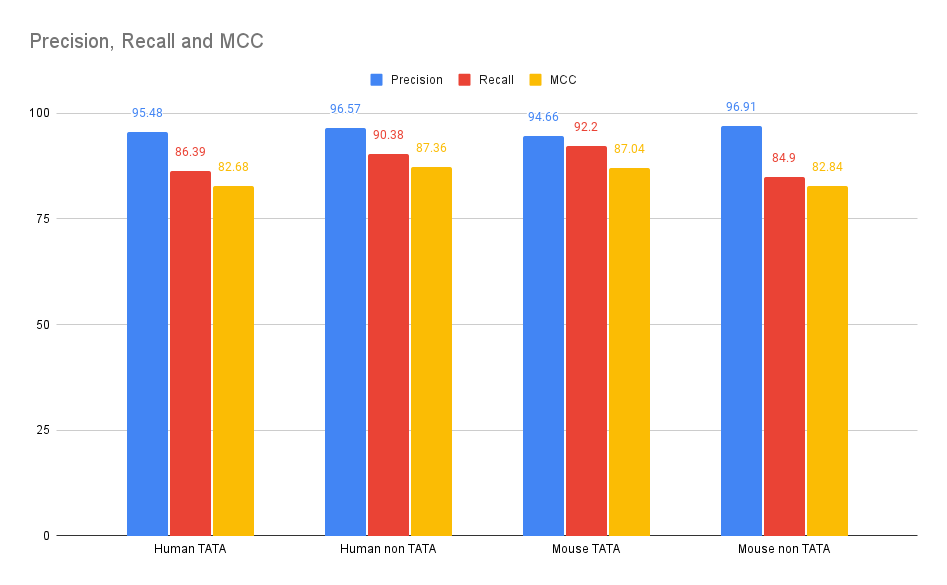